In [1]:
from support.dcmx import DICOMReader
import numpy 
import tensorflow as tf
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Constants

In [2]:
DATA_PATH = '/home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/'
TFRECORDS_PATH_TRAIN = '/home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/lungs_train.tfrecords'
TFRECORDS_PATH_VALID = '/home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/lungs_valid.tfrecords'

LUNG_HEIGHT = 750
LUNG_WIDTH = 400

NUM_EPOCHS = 10
SCALE = 3
VALIDATION_PART = 0.2

Convert DICOM dataset into TFRecords

In [3]:
dcm_reader = DICOMReader()
files = dcm_reader.collect_dcm_filenames(DATA_PATH)
random.shuffle(files)
split = int(len(files) * VALIDATION_PART)
dcm_reader.dcm_to_tfr(files[split:], TFRECORDS_PATH_TRAIN, SCALE)
dcm_reader.dcm_to_tfr(files[:split], TFRECORDS_PATH_VALID, SCALE)

step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image118.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image123.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image076.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image065.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image090.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image086.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image014.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image115.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image092.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image128.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image078.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image038.dcm  0
step: /home/a.dobrenkii/Projects/liberaCAD/data/TbDispensary/image073.dcm  0

(729, 388, 1)
(729, 388, 1)
(936, 378, 1)
(936, 378, 1)
(748, 373, 1)
(748, 373, 1)
(434, 265, 1)
(434, 265, 1)
(726, 341, 1)
(726, 341, 1)
(656, 402, 1)
(656, 403, 1)
(930, 398, 1)
(930, 398, 1)
(856, 414, 1)
(856, 415, 1)
(717, 410, 1)
(717, 410, 1)
(1002, 501, 1)
(1002, 501, 1)
(885, 468, 1)
(885, 469, 1)
(1002, 501, 1)
(1002, 501, 1)
(813, 419, 1)
(813, 420, 1)
(628, 377, 1)
(628, 378, 1)
(841, 390, 1)
(841, 391, 1)
(737, 359, 1)
(737, 359, 1)
(780, 344, 1)
(780, 344, 1)
(765, 441, 1)
(765, 441, 1)
(817, 387, 1)
(817, 388, 1)
(1002, 501, 1)
(1002, 501, 1)
(894, 469, 1)
(894, 470, 1)
(884, 372, 1)
(884, 373, 1)
(786, 376, 1)
(786, 377, 1)
(891, 371, 1)
(891, 372, 1)
(798, 352, 1)
(798, 353, 1)
(753, 439, 1)
(753, 440, 1)
(863, 422, 1)
(863, 423, 1)
(786, 434, 1)
(786, 435, 1)
(654, 384, 1)
(654, 385, 1)
(710, 331, 1)
(710, 331, 1)
(919, 427, 1)
(919, 427, 1)
(661, 396, 1)
(661, 397, 1)
(818, 435, 1)
(818, 436, 1)
(854, 361, 1)
(854, 362, 1)
(694, 341, 1)
(694, 342, 1)
(748, 377, 1)


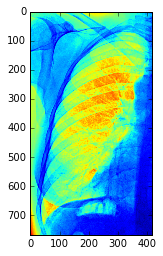

In [5]:
record_iterator = tf.python_io.tf_record_iterator(path=TFRECORDS_PATH_TRAIN)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])

    img_1d = np.fromstring(img_string, dtype=uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    print(reconstructed_img.shape)
    
imshow(reconstructed_img[:, :, 0])

Input producers

In [6]:
def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        })

    image = tf.decode_raw(features['image_raw'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.pack([height, width, 1])
    image = tf.reshape(image, image_shape)
    
    image_size_const = tf.constant((LUNG_HEIGHT, LUNG_WIDTH, 1), dtype=tf.int32)
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=LUNG_HEIGHT,
                                           target_width=LUNG_WIDTH)
    
    resized_image = tf.reshape(resized_image, image_size_const)
#   min_after_dequeue + (num_threads + a small safety margin) * batch_size

    images = tf.train.shuffle_batch([resized_image],
                                    batch_size=2,
                                    capacity=30,
                                    num_threads=1,
                                    min_after_dequeue=2)
    
    return images

Queue produsers

In [7]:
train_queue = tf.train.string_input_producer(
    [TFRECORDS_PATH_TRAIN],
    shuffle=True, 
    num_epochs=NUM_EPOCHS

)

valid_queue = tf.train.string_input_producer(
    [TFRECORDS_PATH_VALID],
    shuffle=True,
)

In [8]:
image = read_and_decode(train_queue)

init_op = tf.group(tf.initialize_all_variables(),
                   tf.initialize_local_variables())

(2, 750, 400, 1)
current batch


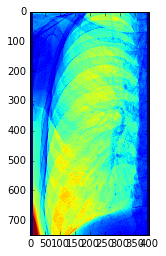

(2, 750, 400, 1)
current batch


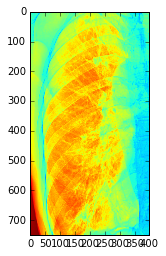

(2, 750, 400, 1)
current batch


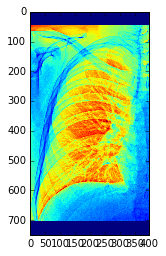

In [10]:
with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(3):
    
        img = sess.run([image])
        print(img[0].shape)
        
        print('current batch')
        
        imshow(img[0][0, :, :, 0])
        show()

    
    coord.request_stop()
    coord.join(threads)